In [55]:
import os
import json
import re
import pandas as pd
from dataclasses import dataclass
from typing import Optional

# ============================================================
# Paths / config
# ============================================================
RESULTS_ROOT = "/mnt/hdd/ttoxopeus/basic_UNet/results"
MODEL_NAME = "UNet_ACDC"  # change if needed

# ============================================================
# 🔁 Switch evaluation mode here (ONLY change this line)
# ============================================================
EVAL_MODE = "retrained"   # "retrained" or "pruned"
#EVAL_MODE = "pruned"


# ============================================================
# Helpers
# ============================================================
def _get_pruned_eval_relpath(eval_mode: str) -> str:
    """Choose which evaluation folder to read for pruned runs."""
    eval_mode = eval_mode.lower().strip()
    if eval_mode in {"retrained", "retrain", "ft", "finetuned"}:
        return os.path.join("retrained_pruned_evaluation", "run_summary.json")
    if eval_mode in {"pruned", "direct", "no_retrain", "noretrain"}:
        return os.path.join("pruned_evaluation", "run_summary.json")
    raise ValueError(f"Unknown eval_mode={eval_mode!r}. Use 'retrained' or 'pruned'.")


def _read_json(path: str) -> dict | None:
    if not os.path.isfile(path):
        return None
    with open(path, "r") as f:
        return json.load(f)


def _extract_threshold(run_name: str) -> float:
    """
    Extract threshold from names like: corr_t92_...
    Returns 0.92 for 't92'. If not found, returns 1.0.
    """
    m = re.search(r"_t(\d+)", run_name)
    if not m:
        return 1.0
    return float(m.group(1)) / 100.0


def _flatten_run_summary(d: dict, run_name: str, run_path: str) -> dict:
    """
    Turns your run_summary.json (new schema) into a single flat row.
    Expands eval.per_class into columns.
    """
    exp = d.get("experiment", {}) or {}
    ev = d.get("eval", {}) or {}
    fg = ev.get("foreground", {}) or {}
    prof = d.get("profile", {}) or {}

    row = {
        "run_name": run_name,
        "run_path": run_path,
        "threshold": _extract_threshold(run_name),
        "stage": d.get("stage"),
        "phase": ev.get("phase"),

        # profile
        "params_m": prof.get("params_m"),
        "flops_g": prof.get("flops_g"),
        "inference_ms": prof.get("inference_ms"),

        # eval
        "vram_peak_mb": ev.get("vram_peak_mb"),
        "mean_dice_fg": fg.get("dice_mean"),
        "std_dice_fg": fg.get("dice_std"),
        "mean_iou_fg": fg.get("iou_mean"),
        "std_iou_fg": fg.get("iou_std"),

        # optional metadata
        "seed": exp.get("seed"),
        "device": exp.get("device"),
        "checkpoint": ev.get("checkpoint"),
    }

    per_class = ev.get("per_class", {}) or {}
    for cls_name, cls_metrics in per_class.items():
        cls_slug = cls_name.lower().replace(" ", "_")
        row[f"{cls_slug}_dice_mean"] = cls_metrics.get("dice_mean")
        row[f"{cls_slug}_dice_std"] = cls_metrics.get("dice_std")
        row[f"{cls_slug}_iou_mean"] = cls_metrics.get("iou_mean")
        row[f"{cls_slug}_iou_std"] = cls_metrics.get("iou_std")

    return row


def load_experiment_eval_df(
    exp_name: str,
    required_substring: str | list[str] | None = None,
    exclude_substrings: str | list[str] | None = None,
    *,
    eval_mode: str = EVAL_MODE,
    baseline_eval_relpath: str = os.path.join("baseline", "evaluation", "run_summary.json"),
    model_name: str = MODEL_NAME,
    results_root: str = RESULTS_ROOT,
) -> pd.DataFrame:
    """
    Returns a DataFrame for one experiment:
    - Row 0 = baseline evaluation
    - Following rows = each pruned run under /pruned/*
    Reads new-schema run_summary.json.

    Filters:
    required_substring: str | list[str] | None
    exclude_substrings: str | list[str] | None
    """

    pruned_eval_relpath = _get_pruned_eval_relpath(eval_mode)
    exp_root = os.path.join(results_root, model_name, exp_name)

    # normalize required
    required_list: list[str] = []
    if isinstance(required_substring, str):
        required_list = [s.strip() for s in required_substring.split(",") if s.strip()]
    elif required_substring:
        required_list = list(required_substring)

    # normalize excludes
    exclude_list: list[str] = []
    if isinstance(exclude_substrings, str):
        exclude_list = [s.strip() for s in exclude_substrings.split(",") if s.strip()]
    elif exclude_substrings:
        exclude_list = list(exclude_substrings)

    # -------- baseline first --------
    baseline_path = os.path.join(exp_root, baseline_eval_relpath)
    baseline_json = _read_json(baseline_path)
    if baseline_json is None:
        raise FileNotFoundError(f"Baseline run_summary.json not found at: {baseline_path}")

    rows = [
        _flatten_run_summary(
            baseline_json,
            run_name="baseline",
            run_path=os.path.dirname(baseline_path),
        )
    ]

    # -------- pruned runs --------
    pruned_dir = os.path.join(exp_root, "pruned")
    if not os.path.isdir(pruned_dir):
        df = pd.DataFrame(rows)
        df["model_size_pct"] = 100.0
        return df

    for run_name in sorted(os.listdir(pruned_dir)):
        run_path = os.path.join(pruned_dir, run_name)
        if not os.path.isdir(run_path):
            continue

        if required_list and not all(req in run_name for req in required_list):
            continue
        if exclude_list and any(excl in run_name for excl in exclude_list):
            continue

        metrics_path = os.path.join(run_path, pruned_eval_relpath)
        d = _read_json(metrics_path)
        if d is None:
            continue

        rows.append(_flatten_run_summary(d, run_name=run_name, run_path=run_path))

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # --------------------------
    # Add model size (% of baseline params)
    # --------------------------
    baseline_params = df.loc[df["run_name"] == "baseline", "params_m"].iloc[0]
    df["model_size_pct"] = 100.0 * df["params_m"] / baseline_params

    # ordering: baseline first, then pruned
    is_baseline = df["run_name"].eq("baseline")
    df_pruned = df.loc[~is_baseline].sort_values(
        ["params_m", "mean_dice_fg"], ascending=[False, False]
    )
    df = pd.concat([df.loc[is_baseline], df_pruned], ignore_index=True)

    front = [
        "run_name",
        "threshold",
        "phase",
        "model_size_pct",
        "params_m",
        "flops_g",
        "inference_ms",
        "vram_peak_mb",
        "mean_dice_fg",
        "std_dice_fg",
        "mean_iou_fg",
        "std_iou_fg",
        "seed",
        "device",
        "checkpoint",
        "run_path",
    ]
    df = df[front + [c for c in df.columns if c not in front]]

    return df


def make_encoder_df(df_total, df_deep, df_decoder):
    # Baseline run_name (first row of total)
    baseline_run = df_total.iloc[0]["run_name"]

    # Collect run_names to remove
    remove_runs = set(df_deep["run_name"]) | set(df_decoder["run_name"])

    # Never remove baseline
    remove_runs.discard(baseline_run)

    # Keep rows not in remove_runs
    df_encoder = df_total[~df_total["run_name"].isin(remove_runs)].copy()
    return df_encoder


# ============================================================
# Data loading (uses EVAL_MODE automatically)
# ============================================================
df_uniform_l1_acdc = load_experiment_eval_df("exp67_uniform_l1_acdc")
df_partial_l1_acdc_encoder = load_experiment_eval_df("exp68_partial_l1_acdc", exclude_substrings="l1_norm_0_0_0")
df_partial_l1_acdc_deep = load_experiment_eval_df("exp68_partial_l1_acdc", exclude_substrings="0_0_0_0_0_0")
df_partial_l1_acdc_decoder = load_experiment_eval_df("exp68_partial_l1_acdc", required_substring="l1_norm_0_0_0_0_0_0")

df_uniform_l1_MM = load_experiment_eval_df("exp74_uniform_l1_MM")
df_partial_l1_MM_encoder = load_experiment_eval_df("exp75_partial_l1_MM", exclude_substrings="l1_norm_0_0_0")
df_partial_l1_MM_deep = load_experiment_eval_df("exp75_partial_l1_MM", exclude_substrings="0_0_0_0_0_0")
df_partial_l1_MM_decoder = load_experiment_eval_df("exp75_partial_l1_MM", required_substring="l1_norm_0_0_0_0_0_0")

df_uniform_corr_acdc = load_experiment_eval_df("exp70_uniform_corr_acdc")
df_partial_corr_acdc_total = load_experiment_eval_df("exp73_partial_corr_acdc")
df_partial_corr_acdc_deep = load_experiment_eval_df("exp73_partial_corr_acdc", exclude_substrings="0_0_0_0_0_0")
df_partial_corr_acdc_decoder = load_experiment_eval_df("exp73_partial_corr_acdc", required_substring="0_0_0_0_0_0_")
df_partial_corr_acdc_encoder = make_encoder_df(
    df_partial_corr_acdc_total,
    df_partial_corr_acdc_deep,
    df_partial_corr_acdc_decoder,
)

df_uniform_corr_MM = load_experiment_eval_df("exp76_uniform_corr_MM")
df_partial_corr_MM_total = load_experiment_eval_df("exp77_partial_corr_MM")
df_partial_corr_MM_deep = load_experiment_eval_df("exp77_partial_corr_MM", exclude_substrings="0_0_0_0_0_0")
df_partial_corr_MM_decoder = load_experiment_eval_df("exp77_partial_corr_MM", required_substring="0_0_0_0_0_0_")
df_partial_corr_MM_encoder = make_encoder_df(
    df_partial_corr_MM_total,
    df_partial_corr_MM_deep,
    df_partial_corr_MM_decoder,
)

pd.set_option("display.max_rows", None)
display(df_partial_corr_MM_encoder)


# ============================================================
# Grouping for easy plotting
# ============================================================
@dataclass
class PruningGroup:
    uniform: pd.DataFrame
    encoder: pd.DataFrame
    deep: pd.DataFrame
    decoder: pd.DataFrame
    total: Optional[pd.DataFrame] = None  # only needed for corr partial_total


dfs = {
    "acdc": {
        "l1": PruningGroup(
            uniform=df_uniform_l1_acdc,
            encoder=df_partial_l1_acdc_encoder,
            deep=df_partial_l1_acdc_deep,
            decoder=df_partial_l1_acdc_decoder,
        ),
        "corr": PruningGroup(
            uniform=df_uniform_corr_acdc,
            encoder=df_partial_corr_acdc_encoder,
            deep=df_partial_corr_acdc_deep,
            decoder=df_partial_corr_acdc_decoder,
            total=df_partial_corr_acdc_total,
        ),
    },
    "mm": {
        "l1": PruningGroup(
            uniform=df_uniform_l1_MM,
            encoder=df_partial_l1_MM_encoder,
            deep=df_partial_l1_MM_deep,
            decoder=df_partial_l1_MM_decoder,
        ),
        "corr": PruningGroup(
            uniform=df_uniform_corr_MM,
            encoder=df_partial_corr_MM_encoder,
            deep=df_partial_corr_MM_deep,
            decoder=df_partial_corr_MM_decoder,
            total=df_partial_corr_MM_total,
        ),
    },
}

print(f"[OK] Loaded dfs with EVAL_MODE={EVAL_MODE!r}")


,run_name,threshold,phase,model_size_pct,params_m,flops_g,inference_ms,vram_peak_mb,mean_dice_fg,std_dice_fg,...,rv_iou_mean,rv_iou_std,myocardium_dice_mean,myocardium_dice_std,myocardium_iou_mean,myocardium_iou_std,lv_dice_mean,lv_dice_std,lv_iou_mean,lv_iou_std
0,baseline,1.00,baseline_evaluation,100.000000,43.886340,54.440493,2.506495,449.635254,0.755246,0.241620,...,0.771552,0.305379,0.664156,0.355898,0.584569,0.331830,0.781202,0.344776,0.735832,0.338096
1,corr_t99_99_99_99_99_99_0_0_0_0_0_0,0.99,retrained_pruned_evaluation,100.000000,43.886340,54.440493,2.512755,282.145996,0.783952,0.232531,...,0.782848,0.295878,0.702333,0.336517,0.622637,0.318347,0.818197,0.318268,0.776452,0.315158
2,corr_t98_99_99_99_99_99_0_0_0_0_0_0,0.98,retrained_pruned_evaluation,99.847962,43.819616,54.329745,2.707229,449.300781,0.779164,0.235338,...,0.788097,0.298481,0.688482,0.348200,0.610679,0.326943,0.815322,0.320962,0.773425,0.317199
3,corr_t96_99_99_99_99_99_0_0_0_0_0_0,0.96,retrained_pruned_evaluation,98.338898,43.157343,53.170356,2.935696,278.642090,0.758870,0.248125,...,0.763730,0.321721,0.678079,0.348994,0.598192,0.326946,0.790063,0.337992,0.744848,0.331531
4,corr_t94_99_99_99_99_99_0_0_0_0_0_0,0.94,retrained_pruned_evaluation,95.184180,41.772853,51.073233,2.993050,359.733398,0.788850,0.232771,...,0.771601,0.315718,0.719770,0.324994,0.640221,0.312127,0.830569,0.304570,0.788577,0.303762
6,corr_t92_99_99_99_99_99_0_0_0_0_0_0,0.92,retrained_pruned_evaluation,92.213101,40.468955,48.822175,2.860289,260.853027,0.785659,0.229613,...,0.765992,0.319947,0.717524,0.326951,0.638151,0.313485,0.829069,0.302758,0.785185,0.301450
9,corr_t88_99_99_99_99_99_0_0_0_0_0_0,0.88,retrained_pruned_evaluation,84.448708,37.061447,44.219884,2.592902,384.252930,0.799504,0.222844,...,0.747068,0.332282,0.753178,0.312850,0.679420,0.305034,0.852582,0.275951,0.809476,0.279646
11,corr_t84_99_99_99_99_99_0_0_0_0_0_0,0.84,retrained_pruned_evaluation,77.224063,33.890815,40.060809,2.355766,257.391113,0.759093,0.255789,...,0.727790,0.345509,0.703446,0.345620,0.628713,0.327252,0.799927,0.336174,0.758712,0.331505
12,corr_t80_99_99_99_99_99_0_0_0_0_0_0,0.80,retrained_pruned_evaluation,70.345319,30.871986,36.815876,2.069068,206.600098,0.774512,0.248293,...,0.742450,0.334298,0.710463,0.338728,0.634803,0.323612,0.824343,0.305332,0.779571,0.305150
15,corr_t75_99_99_99_99_99_0_0_0_0_0_0,0.75,retrained_pruned_evaluation,63.775163,27.988585,34.558106,1.912079,192.382812,0.756320,0.244731,...,0.751949,0.323044,0.659447,0.356817,0.579216,0.331813,0.809043,0.322864,0.765119,0.319400


[OK] Loaded dfs with EVAL_MODE='retrained'


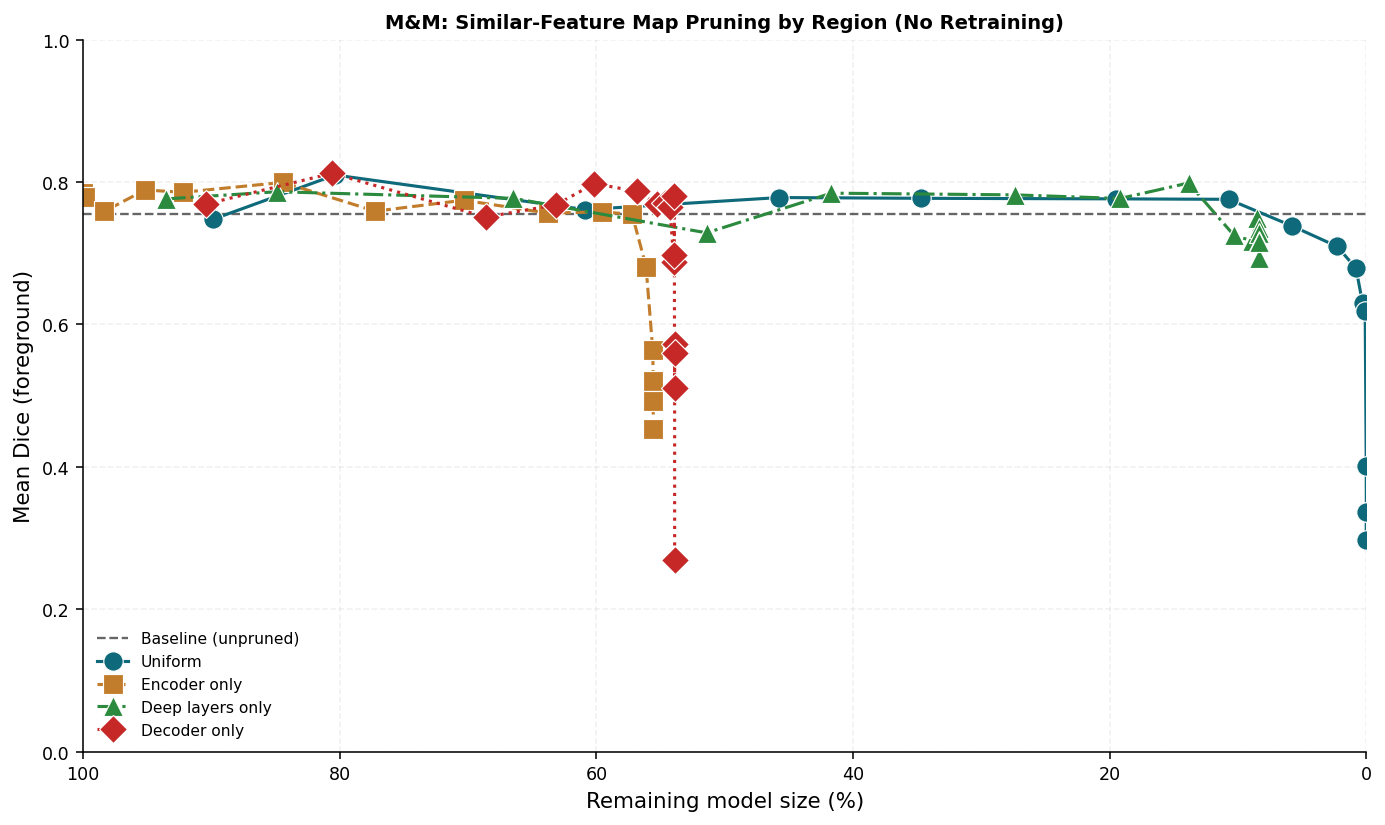

In [38]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

_cwd = Path.cwd().resolve()
_project_root = next((p for p in (_cwd, *_cwd.parents) if (p / "src").exists()), None)
if _project_root is not None and str(_project_root) not in sys.path:
    sys.path.insert(0, str(_project_root))

from src.analysis.plot_style import PUB_COLORS, apply_publication_style, despine

apply_publication_style()

def plot_pruning_locations(
    dfs,
    *,
    dataset: str,
    method: str,
    title: str | None = None,
    save_path: str | None = None,
):
    group = dfs[dataset][method]

    df_uniform = group.uniform
    df_encoder = group.encoder
    df_deep = group.deep
    df_decoder = group.decoder

    fig, ax = plt.subplots(figsize=(10, 6))

    # -------------------------------
    # Baseline (first row in uniform)
    # -------------------------------
    baseline_dice = df_uniform.iloc[0]["mean_dice_fg"]

    ax.axhline(
        baseline_dice,
        linestyle="--",
        linewidth=1.2,
        color="black",
        alpha=0.6,
        label="Baseline (unpruned)",
    )

    lines = [
        (df_uniform, "Uniform", "o", "-", PUB_COLORS["l1"]),
        (df_encoder, "Encoder only", "s", "--", PUB_COLORS["neutral"]),
        (df_deep, "Deep layers only", "^", "-.", PUB_COLORS["good"]),
        (df_decoder, "Decoder only", "D", ":", PUB_COLORS["warn"]),
    ]

    for df, label, marker, linestyle, color in lines:
        df_plot = df.iloc[1:]  # skip baseline point; keep only pruned runs
        ax.plot(
            df_plot["model_size_pct"],
            df_plot["mean_dice_fg"],
            label=label,
            marker=marker,
            linestyle=linestyle,
            linewidth=1.6,
            markersize=10,
            markeredgecolor="white",
            markeredgewidth=0.6,
            color=color,
        )

    ax.set_xlabel("Remaining model size (%)")
    ax.set_ylabel("Mean Dice (foreground)")

    if title is None:
        title = f"{dataset.upper()} — {method.upper()} pruning by region"
    ax.set_title(title, fontsize=10, pad=6)

    # Flip x-axis: 100 -> 0
    ax.set_xlim(max(df_uniform["model_size_pct"]), 0)
    ax.set_ylim(0.0, 1.0)

    despine(ax)
    ax.legend(frameon=False, fontsize=8, loc="lower left")

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()

    plt.close(fig)

plot_pruning_locations(
    dfs,
    dataset="mm",
    method="corr",
    title="M&M: Similar-Feature Map Pruning by Region (No Retraining)",
    # save_path="figures/results/mm_corr_pruning_locations.pdf",
)


/media/ttoxopeus/tmp/ipykernel_1903878/1837242084.py:338: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


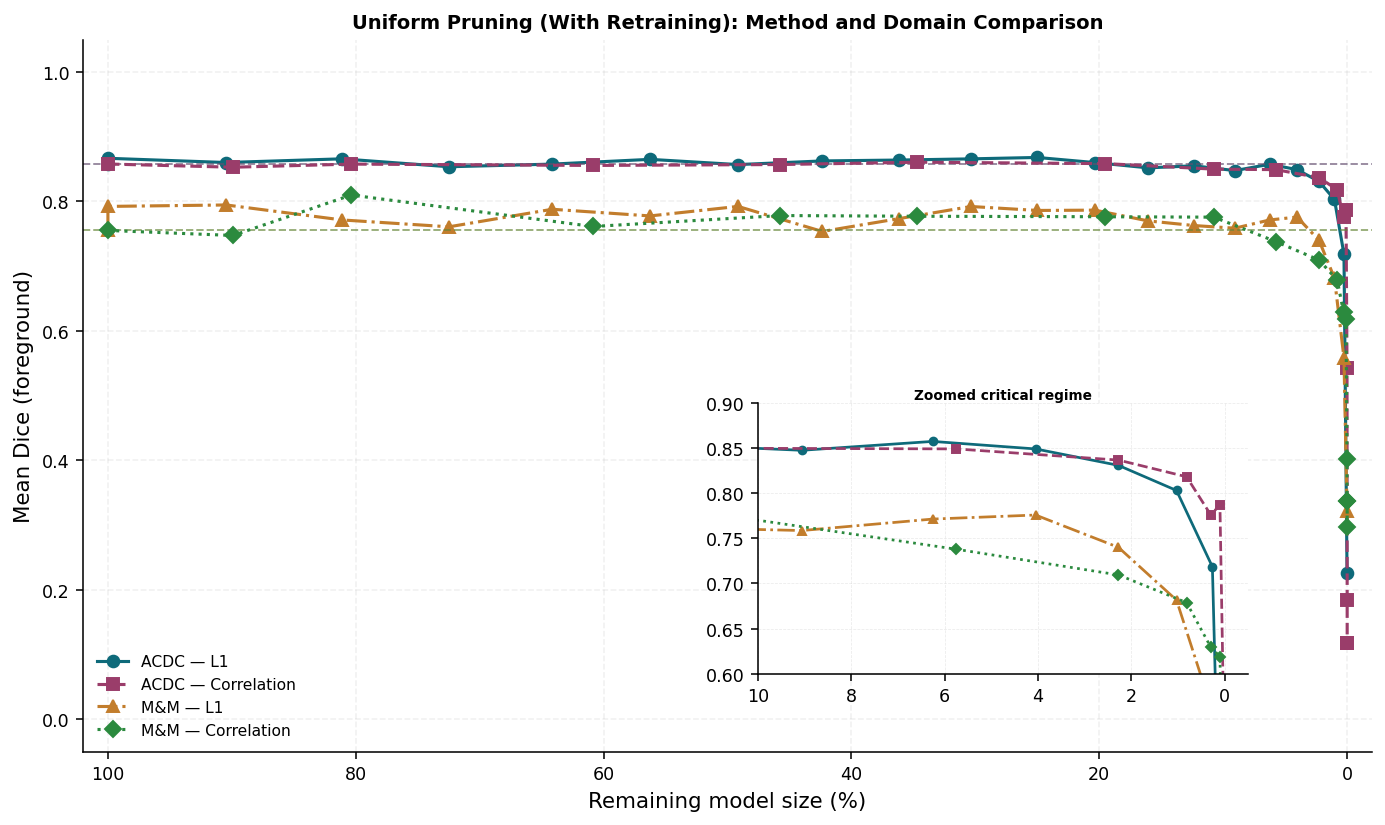

In [54]:
# import matplotlib.pyplot as plt
# import pandas as pd
# from src.analysis.plot_style import PUB_COLORS, apply_publication_style, despine

# apply_publication_style()

# def plot_experiment_dfs(
#     dfs_by_label,
#     *,
#     include_baseline_point: bool = True,
#     gap_labels: tuple[str, str] | None = None,  # Optional ("A","B")
#     gap_label: str = "Difference (A - B)",
#     title=None,
#     save_path=None,
# ):
#     """
#     Plot multiple experiment dataframes in one figure.
#     Pass: {"label": df, ...}

#     If gap_labels=("A","B"), also plots:
#         gap = Dice_A - Dice_B
#     """

#     fig, ax = plt.subplots(figsize=(10, 6))
#     x_max = 0.0
#     y_min, y_max = 0.0, 1.0

#     # --------------------------------------------------
#     # Plot main curves
#     # --------------------------------------------------
#     palette = [
#         PUB_COLORS["l1"],
#         PUB_COLORS["corr"],
#         PUB_COLORS["neutral"],
#         PUB_COLORS["good"],
#         PUB_COLORS["warn"],
#     ]
#     markers = ["o", "s", "^", "D", "P", "X", "v", "*"]
#     linestyles = ["-", "--", "-.", ":"]

#     for i, (label, df) in enumerate(dfs_by_label.items()):
#         if df is None or df.empty:
#             continue

#         baseline_dice = df.iloc[0]["mean_dice_fg"]
#         if include_baseline_point:
#             df_plot = df[["model_size_pct", "mean_dice_fg"]].copy()
#         else:
#             df_plot = df.iloc[1:][["model_size_pct", "mean_dice_fg"]].copy()
#         df_plot = df_plot.sort_values("model_size_pct", ascending=False)

#         color = palette[i % len(palette)]
#         marker = markers[i % len(markers)]
#         linestyle = linestyles[i % len(linestyles)]

#         line = ax.plot(
#             df_plot["model_size_pct"],
#             df_plot["mean_dice_fg"],
#             marker=marker,
#             linestyle=linestyle,
#             linewidth=1.6,
#             markersize=6,
#             color=color,
#             label=label,
#         )


#         # baseline line
#         ax.axhline(
#             baseline_dice,
#             linestyle="--",
#             linewidth=1.0,
#             color=color,
#             alpha=0.5,
#         )

#         x_max = max(x_max, float(df["model_size_pct"].max()))

#     # --------------------------------------------------
#     # Optional gap plotting
#     # --------------------------------------------------
#     if gap_labels is not None:
#         a_label, b_label = gap_labels
#         df_a = dfs_by_label.get(a_label)
#         df_b = dfs_by_label.get(b_label)

#         if df_a is None or df_b is None:
#             raise ValueError("gap_labels refer to missing dfs.")

#         a = df_a.iloc[1:][["model_size_pct", "mean_dice_fg"]].copy()
#         b = df_b.iloc[1:][["model_size_pct", "mean_dice_fg"]].copy()

#         merged = a.merge(
#             b,
#             on="model_size_pct",
#             how="inner",
#             suffixes=("_a", "_b"),
#         )

#         if not merged.empty:
#             merged["gap"] = (
#                 merged["mean_dice_fg_a"] -
#                 merged["mean_dice_fg_b"]
#             )

#             ax.plot(
#                 merged["model_size_pct"],
#                 merged["gap"],
#                 marker="x",
#                 linestyle="--",
#                 linewidth=1.6,
#                 markersize=6,
#                 label=gap_label,
#             )

#             # adjust y-limits if needed
#             y_min = min(y_min, merged["gap"].min())
#             y_max = max(y_max, merged["gap"].max())

#     # --------------------------------------------------
#     # Axes styling
#     # --------------------------------------------------
#     x_pad = 0.02 * x_max if x_max > 0 else 1.0
#     ax.set_xlim(x_max + x_pad, 0 - x_pad)

#     # Expand y-limits slightly if gap included
#     y_pad = 0.05 * (y_max - y_min if y_max > y_min else 1.0)
#     ax.set_ylim(y_min - y_pad, y_max + y_pad)

#     ax.set_xlabel("Remaining model size (%)")
#     ax.set_ylabel("Mean Dice (foreground)")

#     if title is not None:
#         ax.set_title(title, fontsize=10, pad=6)

#     despine(ax)
#     ax.legend(frameon=False, fontsize=8, loc="lower left")
#     fig.tight_layout()

#     if save_path is not None:
#         fig.savefig(save_path, dpi=300, bbox_inches="tight")
#     else:
#         plt.show()

#     plt.close(fig)



# plot_experiment_dfs(
#     {
#         "ACDC — L1": dfs["acdc"]["l1"].uniform,
#         "ACDC — Correlation": dfs["acdc"]["corr"].uniform,
#         "M&M — L1": dfs["mm"]["l1"].uniform,
#         "M&M — Correlation": dfs["mm"]["corr"].uniform,
#     },
#     include_baseline_point=True,
#     title="Uniform Pruning (No Retraining): Method and Domain Comparison",
# )



import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from src.analysis.plot_style import PUB_COLORS, apply_publication_style, despine

apply_publication_style()

def plot_experiment_dfs(
    dfs_by_label,
    *,
    include_baseline_point: bool = True,
    gap_labels: tuple[str, str] | None = None,
    gap_label: str = "Difference (A - B)",
    zoom_region: tuple[float, float, float, float] | None = None,  # (x_min, x_max, y_min, y_max)
    title=None,
    save_path=None,
):
    """
    Plot multiple experiment dataframes in one figure.

    Pass: {"label": df, ...}

    Optional:
    - gap_labels=("A","B") to plot Dice_A - Dice_B
    - zoom_region=(x_min, x_max, y_min, y_max) to add inset zoom
    """

    fig, ax = plt.subplots(figsize=(10, 6))
    x_max = 0.0
    y_min, y_max = 0.0, 1.0

    palette = [
        PUB_COLORS["l1"],
        PUB_COLORS["corr"],
        PUB_COLORS["neutral"],
        PUB_COLORS["good"],
        PUB_COLORS["warn"],
    ]
    markers = ["o", "s", "^", "D", "P", "X", "v", "*"]
    linestyles = ["-", "--", "-.", ":"]

    plotted_lines = []

    # --------------------------------------------------
    # Plot main curves
    # --------------------------------------------------
    for i, (label, df) in enumerate(dfs_by_label.items()):
        if df is None or df.empty:
            continue

        baseline_dice = df.iloc[0]["mean_dice_fg"]

        if include_baseline_point:
            df_plot = df[["model_size_pct", "mean_dice_fg"]].copy()
        else:
            df_plot = df.iloc[1:][["model_size_pct", "mean_dice_fg"]].copy()

        df_plot = df_plot.sort_values("model_size_pct", ascending=False)

        color = palette[i % len(palette)]
        marker = markers[i % len(markers)]
        linestyle = linestyles[i % len(linestyles)]

        line = ax.plot(
            df_plot["model_size_pct"],
            df_plot["mean_dice_fg"],
            marker=marker,
            linestyle=linestyle,
            linewidth=1.6,
            markersize=6,
            color=color,
            label=label,
        )

        plotted_lines.append((df_plot, color, marker, linestyle))

        ax.axhline(
            baseline_dice,
            linestyle="--",
            linewidth=1.0,
            color=color,
            alpha=0.4,
        )

        x_max = max(x_max, float(df["model_size_pct"].max()))

    # --------------------------------------------------
    # Optional gap plotting
    # --------------------------------------------------
    if gap_labels is not None:
        a_label, b_label = gap_labels
        df_a = dfs_by_label.get(a_label)
        df_b = dfs_by_label.get(b_label)

        if df_a is None or df_b is None:
            raise ValueError("gap_labels refer to missing dfs.")

        a = df_a.iloc[1:][["model_size_pct", "mean_dice_fg"]].copy()
        b = df_b.iloc[1:][["model_size_pct", "mean_dice_fg"]].copy()

        merged = a.merge(
            b,
            on="model_size_pct",
            how="inner",
            suffixes=("_a", "_b"),
        )

        if not merged.empty:
            merged["gap"] = (
                merged["mean_dice_fg_a"] -
                merged["mean_dice_fg_b"]
            )

            ax.plot(
                merged["model_size_pct"],
                merged["gap"],
                marker="x",
                linestyle="--",
                linewidth=1.6,
                markersize=6,
                label=gap_label,
            )

            y_min = min(y_min, merged["gap"].min())
            y_max = max(y_max, merged["gap"].max())

    # --------------------------------------------------
    # Axes styling
    # --------------------------------------------------
    x_pad = 0.02 * x_max if x_max > 0 else 1.0
    ax.set_xlim(x_max + x_pad, 0 - x_pad)

    y_pad = 0.05 * (y_max - y_min if y_max > y_min else 1.0)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)

    ax.set_xlabel("Remaining model size (%)")
    ax.set_ylabel("Mean Dice (foreground)")

    if title is not None:
        ax.set_title(title, fontsize=10, pad=6)

    despine(ax)
    ax.legend(frameon=False, fontsize=8, loc="lower left")

    # --------------------------------------------------
    # Optional inset zoom
    # --------------------------------------------------
    if zoom_region is not None:
        x_min_z, x_max_z, y_min_z, y_max_z = zoom_region

        axins = inset_axes(
            ax,
            width="38%",
            height="38%",
            loc="lower right",
            bbox_to_anchor=(-0.08, 0.08, 1, 1),  # shift left & up
            bbox_transform=ax.transAxes,
            borderpad=1.2,
        )
        for df_plot, color, marker, linestyle in plotted_lines:
            axins.plot(
                df_plot["model_size_pct"],
                df_plot["mean_dice_fg"],
                marker=marker,
                linestyle=linestyle,
                linewidth=1.4,
                markersize=4,
                color=color,
            )

        axins.set_xlim(x_max_z, x_min_z)
        axins.set_ylim(y_min_z, y_max_z)
        axins.set_title("Zoomed critical regime", fontsize=7, pad=2)

        axins.grid(True, alpha=0.25, linewidth=0.4)

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()

    plt.close(fig)


# --------------------------------------------------
# Example call with zoom
# --------------------------------------------------
plot_experiment_dfs(
    {
        "ACDC — L1": dfs["acdc"]["l1"].uniform,
        "ACDC — Correlation": dfs["acdc"]["corr"].uniform,
        "M&M — L1": dfs["mm"]["l1"].uniform,
        "M&M — Correlation": dfs["mm"]["corr"].uniform,
    },
    include_baseline_point=True,
    zoom_region=(-0.5, 10, 0.6, 0.9),  # <- zoom into critical region
    title="Uniform Pruning (With Retraining): Method and Domain Comparison",
)
